# Knet CNN Example

#### Comparison with other frameworks from https://github.com/ilkarman/DeepLearningFrameworks

| DL Library                               | Test Accuracy (%) | Training Time (s) |
| ---------------------------------------- | ----------------- | ----------------- |
| [Knet](Knet_CNN.ipynb)                   | 78                | 148               |
| [Caffe2](Caffe2_CNN.ipynb)               | 79                | 149               |
| [MXNet](MXNet_CNN.ipynb)                 | 77                | 149               |
| [Gluon](Gluon_CNN.ipynb)                 | 77                | 157               |
| [CNTK](CNTK_CNN.ipynb)                   | 78                | 166               |
| [PyTorch](PyTorch_CNN.ipynb)             | 78                | 168               |
| [Tensorflow](Tensorflow_CNN.ipynb)       | 78                | 173               |
| [Keras(CNTK)](Keras_CNTK_CNN.ipynb)      | 78                | 200               |
| [Chainer](Chainer_CNN.ipynb)             | 79                | 240               |
| [Keras(TF)](Keras_TF_CNN.ipynb)          | 77                | 252               |
| [Lasagne(Theano)](Theano_Lasagne_CNN.ipynb) | 77                | 253               |
| [Keras(Theano)](Keras_Theano_CNN.ipynb)  | 78                | 269               |


#### After installing and starting Julia run the following to install the required packages:
```
julia> Pkg.init(); for p in ("CUDAdrv","IJulia","Knet"); Pkg.add(p); end
```

In [1]:
using Knet
EPOCHS = 10
BATCHSIZE = 64
LR = 0.01
MOMENTUM = 0.9
N_CLASSES = 10;

In [2]:
println("OS: ", Sys.KERNEL)
println("Julia: ", VERSION)
println("Knet: ", Pkg.installed("Knet"))
println("GPU: ", readstring(`nvidia-smi --query-gpu=name --format=csv,noheader`))

OS: Linux
Julia: 0.6.1
Knet: 0.8.5+
GPU: Tesla K80
Tesla K80



In [3]:
# define model
function initmodel(; atype=KnetArray, dtype=Float32, winit=xavier, binit=zeros)
    w(dims...)=atype(winit(dtype,dims...))
    b(dims...)=atype(binit(dtype,dims...))
    return Any[
        w(3,3,3,50), b(1,1,50,1),
        w(3,3,50,50), b(1,1,50,1),
        w(3,3,50,100), b(1,1,100,1),
        w(3,3,100,100), b(1,1,100,1),
        w(512,6400), b(512,1),
        w(N_CLASSES,512), b(N_CLASSES,1)
    ]
end;

In [4]:
# define loss and its gradient
function predict(w,x)
    convbias(x,w,b) = conv4(w,x;padding=1) .+ b
    fc(x,w,b) = w * mat(x) .+ b;
    x = relu.(convbias(x,w[1],w[2]))
    x = relu.(pool(convbias(x,w[3],w[4])))
    x = dropout(x,0.25)
    x = relu.(convbias(x,w[5],w[6]))
    x = relu.(pool(convbias(x,w[7],w[8])))
    x = dropout(x,0.25)
    x = relu.(fc(x,w[9],w[10]))
    x = dropout(x,0.5)
    return fc(x,w[11],w[12])
end

loss(w,x,y)=nll(predict(w,x),y) # nll: negative log likelihood
lossgradient = grad(loss);

In [5]:
# load data
include(Knet.dir("data","cifar.jl"))
@time (xtrn,ytrn,xtst,ytst,lbls)=cifar10()
for d in (xtrn,ytrn,xtst,ytst); println(summary(d)); end

INFO: Reading cifar-10-binary.tar.gz...


  3.346628 seconds (1.29 M allocations: 1.784 GiB, 18.76% gc time)
32×32×3×50000 Array{Float32,4}
50000-element Array{UInt8,1}
32×32×3×10000 Array{Float32,4}
10000-element Array{UInt8,1}


String["ship", "truck", "automobile"]


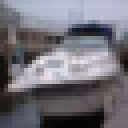

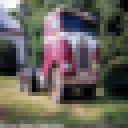

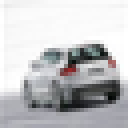

In [6]:
# Some sample images and classes from CIFAR-10
using Images
rp = randperm(10000)
println(lbls[ytst[rp[1:3]]]); flush(STDOUT)
for i=1:3; display(cifarview(xtst,rp[i])); end

In [7]:
# prepare for training
model = initmodel()
optim = optimizers(model, Momentum; lr=LR, gamma=MOMENTUM);

In [8]:
# force precompile (optional)
info("Precompile...")
x1 = KnetArray(xtrn[:,:,:,1:BATCHSIZE])
y1 = ytrn[1:BATCHSIZE]
@time lossgradient(model,x1,y1);

INFO: Precompile...


  9.046027 seconds (2.15 M allocations: 113.366 MiB, 40.29% gc time)


In [9]:
info("Training...")
@time for epoch in 1:EPOCHS
    @time for (x,y) in minibatch(xtrn,ytrn,BATCHSIZE;shuffle=true,xtype=KnetArray)
        grads = lossgradient(model, x, y)
        update!(model, grads, optim)
    end
end

INFO: Training...


 14.832824 seconds (2.23 M allocations: 685.405 MiB, 0.49% gc time)
 14.155661 seconds (1.98 M allocations: 671.379 MiB, 0.46% gc time)
 14.189869 seconds (1.98 M allocations: 671.473 MiB, 0.56% gc time)
 14.205895 seconds (1.98 M allocations: 671.379 MiB, 0.50% gc time)
 14.240342 seconds (1.98 M allocations: 671.379 MiB, 0.54% gc time)
 14.236751 seconds (1.98 M allocations: 671.379 MiB, 0.46% gc time)
 14.262262 seconds (1.98 M allocations: 671.379 MiB, 0.44% gc time)
 14.241114 seconds (1.98 M allocations: 671.379 MiB, 0.43% gc time)
 14.259997 seconds (1.98 M allocations: 671.379 MiB, 0.48% gc time)
 14.282991 seconds (1.98 M allocations: 671.379 MiB, 0.46% gc time)
142.912236 seconds (20.06 M allocations: 6.571 GiB, 0.48% gc time)


In [10]:
# test accuracy
info("Testing...")
testdata = minibatch(xtst,ytst,BATCHSIZE;xtype=KnetArray)
@time accuracy(model,testdata,predict)

INFO: Testing...


  1.811974 seconds (514.55 k allocations: 143.190 MiB, 1.25% gc time)


0.7705328525641025